If you are interested in graident boosting, here is a good place to start: https://xgboost.readthedocs.io/en/latest/tutorials/model.html

This is a supervised machine learning method.

In [1]:
!pip install catboost
!pip install scikit-learn --upgrade

     |████████████████████████████████| 65.8MB 133kB/s 
     |████████████████████████████████| 22.2MB 1.2MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
# If you have installation questions, please reach out

import pandas as pd # data storage
import catboost as cats # graident boosting 

from catboost import CatBoostRegressor, Pool

import datetime
import numpy as np  # math and stuff
import matplotlib.pyplot as plt # plotting utility
import sklearn # ML and stats

print('catboost ver:', cats.__version__)
print('scikit ver:', sklearn.__version__)

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import max_error, mean_squared_error, median_absolute_error


catboost ver: 0.24.4
scikit ver: 0.24.1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('drive/My Drive/1_lewis_research/core_to_wl_merge/Merged_dataset_inner_imputed_12_21_2020.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let's drop some columns, and show off some of the data

In [5]:
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'LiveTime2','ScanTime2', 'LiveTime1','ScanTime1',
              'ref_num', 'API', 'well_name', 'sample_num' ], axis=1)

print(df.columns.values) # printing all column names

df.describe()

['depth_ft' 'USGS_ID' 'CAL' 'GR' 'DT' 'SP' 'DENS' 'PE' 'RESD' 'PHIN'
 'PHID' 'PE_smooth' 'GR_smooth' 'gz_linear_interp' 'gz_pchip_interp'
 'perm_air_md' 'perm_klink_md' 'He_por' 'horz_perm_md' 'effective_por'
 'por_percent' 'stress_swanson_perm_md' 'sample' 'Na' 'Na Err' 'Mg'
 'Mg Err' 'Al' 'Al Err' 'Si' 'Si Err' 'P' 'P Err' 'S' 'S Err' 'K' 'K Err'
 'Ca' 'Ca Err' 'Ti' 'Ti Err' 'Cr' 'Cr Err' 'Mn' 'Mn Err' 'Fe' 'Fe Err'
 'Co' 'Co Err' 'Ni' 'Ni Err' 'Cu' 'Cu Err' 'Zn' 'Zn Err' 'Ba' 'Ba Err']


,depth_ft,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,PE_smooth,GR_smooth,gz_linear_interp,gz_pchip_interp,perm_air_md,perm_klink_md,He_por,horz_perm_md,effective_por,por_percent,stress_swanson_perm_md,Na,Na Err,Mg,Mg Err,Al,Al Err,Si,Si Err,P,P Err,S,S Err,K,K Err,Ca,Ca Err,Ti,Ti Err,Cr,Cr Err,Mn,Mn Err,Fe,Fe Err,Co,Co Err,Ni,Ni Err,Cu,Cu Err,Zn,Zn Err,Ba,Ba Err
count,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,508.000000,510.000000,510.000000,25.000000,25.000000,24.000000,24.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.0,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000
mean,5397.863358,0.468406,0.325999,0.430844,0.811259,0.613371,0.351642,1.011018,0.172737,0.172737,0.351702,0.326029,4.913576,4.910244,81.002187,73.797216,14.267039,8.304000,11.808000,8.420833,1.646585,1.132042,0.025387,0.762913,0.011739,3.490170,0.012272,32.981494,0.033185,0.048516,0.001821,0.728955,0.002247,1.675288,0.005710,2.779623,0.005543,0.190546,0.001373,0.005787,0.000116,0.016520,0.000705,1.941109,0.003196,0.001315,0.0,0.004773,0.000100,0.003211,0.000822,0.006309,0.000763,0.090289,0.004689
std,5106.156677,0.191316,0.237404,0.263514,0.162843,0.214604,0.186912,1.503608,0.226664,0.226664,0.178735,0.229901,1.738128,1.751499,173.917355,161.251984,9.365678,3.161814,4.446902,3.050728,3.741652,0.777851,0.004405,0.488501,0.002843,1.415185,0.002607,4.940991,0.002003,0.023636,0.000221,0.795110,0.001252,0.761818,0.001383,2.045850,0.002189,0.088087,0.000297,0.002270,0.000075,0.024982,0.000128,1.472163,0.001193,0.000821,0.0,0.000796,0.000002,0.004429,0.000114,0.004559,0.000100,0.065308,0.000594
min,150.000000,0.000000,0.000000,0.003752,0.000000,0.000000,0.000000,-0.744314,0.000570,0.000570,0.004477,0.000258,1.204296,1.199972,0.001000,0.000000,1.000000,1.900000,5.900000,4.000000,0.000390,0.126200,0.016000,0.047000,0.006800,0.992200,0.007100,8.429500,0.021700,0.000000,0.001100,0.040300,0.000600,0.118400,0.002000,0.133500,0.001400,0.048500,0.000800,0.000000,-0.001200,0.000000,0.000500,0.270700,0.001300,0.000200,0.0,0.002700,0.000100,0.000000,0.000200,0.000000,0.000500,0.000000,0.003100
25%,450.725000,0.360072,0.122318,0.174146,0.743878,0.424460,0.216157,-0.037336,0.004595,0.004595,0.220800,0.131058,3.538724,3.531571,0.040750,0.020250,8.300000,7.900000,8.400000,6.800000,0.001140,0.768500,0.023400,0.293850,0.009100,2.411025,0.010200,29.728050,0.032000,0.032400,0.001700,0.182225,0.001200,1.069725,0.004600,1.103025,0.003600,0.121875,0.001100,0.004400,0.000100,0.003200,0.000600,0.964250,0.002300,0.000700,0.0,0.004300,0.000100,0.000000,0.000700,0.002700,0.000700,0.053200,0.004300
50%,1614.650000,0.554827,0.275825,0.471657,0.867010,0.605516,0.329327,0.795008,0.005532,0.005532,0.337049,0.283192,4.307541,4.256191,0.065500,0.037500,9.300000,9.500000,10.600000,7.300000,0.002070,1.057300,0.025200,0.692000,0.011700,3.133250,0.011700,31.893100,0.033300,0.047250,0.001800,0.461450,0.001900,1.560450,0.005800,2.593250,0.005700,0.160300,0.001300,0.005400,0.000100,0.014200,0.000700,1.658800,0.003100,0.001200,0.0,0.004800,0.000100,0.000000,0.000800,0.005400,0.000800,0.079300,0.004700
75%,9649.575000,0.602566,0.530980,0.662807,0.925012,0.830179,0.470706,1.378387,0.332503,0.332503,0.463317,0.525448,6.615175,6.633493,71.375000,59.675000,26.610000,10.300000,13.800000,9.200000,0.949777,1.322750,0.026700,1.192400,0.014400,4.531475,0.014400,37.944075,0.034700,0.061800,0.002000,0.941100,0.002900,2.291400,0.006900,3.872700,0.007000,0.258025,0.001600,0.006800,0.000100,0.023400,0.000800,2.616775,0.003900,0.001700,0.0,0.005200,0.000100,0.006300,0.000900,0.009200,0.0

This is the dataset we want to test/train on. Should have features along with what we are trying to predict. 

In [6]:
dataset = df[[
    'CAL', 'GR', 'DT', 'SP', 'DENS', 'PE',
    'RESD', 'PHIN', 'PHID', 'GR_smooth', 
    'PE_smooth',
    'gz_pchip_interp' # Trying to predict gz_pchip_interp
]]

In the next code block, we will remove the rows without data, and change string NaN's to np.nans

In [7]:
dataset.replace('NaN',np.nan, regex=True, inplace=True)# Should be good already
# dataset = dataset.dropna() # not needed

dataset.head(3)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,GR_smooth,PE_smooth,gz_pchip_interp
0,0.630495,0.187403,0.054025,0.582081,0.829176,0.349137,0.982069,0.001692,0.001692,0.183350,0.366294,4.0320
1,0.629618,0.186340,0.054025,0.583138,0.828532,0.346560,0.970108,0.001674,0.001674,0.185719,0.364550,3.9834
2,0.628741,0.185373,0.054025,0.584257,0.827725,0.349993,0.958103,0.001662,0.001662,0.188207,0.362606,3.9836


In [8]:
# Features we will use for prediction
X = dataset[['CAL', 'GR', 'DT', 'SP', 'DENS', 'PE',
        'RESD', 'PHIN', 'PHID', 
        'GR_smooth', 
        'PE_smooth']]

# What we are trying to predict
Y = dataset[['gz_pchip_interp']]

Y_array = np.array(Y.values)

## Starting to set up the ML model params

Setting up the test and train sets.

In [9]:
seed = 42 # random seed is only used if you want to compare exact answers with friends 
test_size = 0.25 # how much data you want to withold, .15 - 0.3 is a good starting point

X_train, X_test, y_train, y_test = train_test_split(X.values, Y_array, test_size=test_size)

### Let's try some hyperparameter tuning (this takes forever!)

Hyperparameter testing does a grid search to find the best parameters, out of the parameters below. This turned out to be really slow on my laptop. Please skip this! 

In [10]:
model = CatBoostRegressor(objective='RMSE', iterations=3000)

model.fit(X_train, y_train, verbose=1000 )

preds = model.predict(X_test)

rmse = mean_squared_error(y_test, preds, squared=False)
print("Root Mean Squared Error: %f" % (rmse))
max = max_error(y_test, preds)
print("Max Error: %f" % (max))

MAE= median_absolute_error(y_test, preds)
print("Median Abs Error: %f" % (max))

Learning rate set to 0.025051
0:	learn: 1.7315301	total: 52.8ms	remaining: 2m 38s
1000:	learn: 0.7452106	total: 3.77s	remaining: 7.54s
2000:	learn: 0.6112754	total: 7.66s	remaining: 3.82s
2999:	learn: 0.5392617	total: 11.5s	remaining: 0us
Root Mean Squared Error: 0.665842
Max Error: 3.663624
Median Abs Error: 3.663624


In [11]:
print(model.feature_names_)

print(model.feature_importances_)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
[ 7.94089539  6.41947758 10.60345264 12.72466562  7.67404019  5.10661113
 13.29957727  5.31041775  4.12133859 19.99508632  6.80443753]


### Parameters to search during tuning

In [12]:
grid = {'learning_rate': [0.1, 0.2, 0.4],
        'depth': [6, 8, 10,  12, 14],
        'l2_leaf_reg': [2, 3, 4 , 5, 6 ]}

model_grid = CatBoostRegressor(objective='RMSE', iterations=1200)

# Grid Search
grid_search_result = model_grid.grid_search(grid, 
                                            X=X_train, 
                                            y=y_train, 
                                            cv=5,
                                            verbose=False
                                       )


bestTest = 0.73311431
bestIteration = 1198


bestTest = 0.7255735003
bestIteration = 1114


bestTest = 0.7448293953
bestIteration = 768


bestTest = 0.7385410648
bestIteration = 1199


bestTest = 0.7255096245
bestIteration = 1141


bestTest = 0.7399518354
bestIteration = 1063


bestTest = 0.7380351928
bestIteration = 1199


bestTest = 0.7244595883
bestIteration = 1170


bestTest = 0.7428234356
bestIteration = 1196


bestTest = 0.745241025
bestIteration = 1199


bestTest = 0.7286930159
bestIteration = 1193


bestTest = 0.7399607646
bestIteration = 1003


bestTest = 0.7469814746
bestIteration = 1198


bestTest = 0.7305633767
bestIteration = 1195


bestTest = 0.7444892027
bestIteration = 1071


bestTest = 0.7077117958
bestIteration = 1199


bestTest = 0.7042499595
bestIteration = 1186


bestTest = 0.7448676368
bestIteration = 1102


bestTest = 0.7115754787
bestIteration = 1190


bestTest = 0.7025962592
bestIteration = 1185


bestTest = 0.7265710014
bestIteration = 1057


bestTest = 0.713

In [13]:
grid_search_result['params']

{'depth': 14, 'l2_leaf_reg': 4, 'learning_rate': 0.1}

Now plug in the hyperparameters into the training model.

In [18]:
model2 = CatBoostRegressor(objective='RMSE',
                           depth=grid_search_result['params']['depth'],
                           l2_leaf_reg=grid_search_result['params']['l2_leaf_reg'],
                           learning_rate=grid_search_result['params']['learning_rate'],
                           iterations=2000)

model2.fit(X_train, y_train, verbose=500 )

preds2 = model2.predict(X_test)

rmse2 = mean_squared_error(y_test, preds2, squared=False)
print("Root Mean Squared Error: %f" % (rmse))
max2 = max_error(y_test, preds2)
print("Max Error: %f" % (max2))

MAE2= median_absolute_error(y_test, preds2)
print("Median Abs Error: %f" % (MAE2))

0:	learn: 1.6547971	total: 316ms	remaining: 10m 32s
500:	learn: 0.3390282	total: 2m 34s	remaining: 7m 43s
1000:	learn: 0.2206194	total: 5m 9s	remaining: 5m 8s
1500:	learn: 0.1548246	total: 7m 44s	remaining: 2m 34s
1999:	learn: 0.1139501	total: 10m 18s	remaining: 0us
Root Mean Squared Error: 0.665842
Max Error: 4.011165
Median Abs Error: 0.093807


# Exporting

In [15]:
x = datetime.datetime.now()

d = {'target': [Y.columns.values, Y.columns.values],
     'MSE': [rmse, rmse2],
     'MAE': [MAE, MAE2],
     'MaxError': [max, max2], 
     'day': [x.day, x.day], 
     'month':[x.month, x.month], 
     'year':[x.year, x.year],
     'model':['catboost', 'catboost'],
     'version':[cats.__version__, cats.__version__ ]}

results = pd.DataFrame(data=d)

results.to_csv('drive/My Drive/1_lewis_research/analysis/experiments/catboost/catboost_results/grainsize_cat.csv')

results

,target,MSE,MAE,MaxError,day,month,year,model,version
0,[gz_pchip_interp],0.665842,0.230579,3.663624,21,2,2021,catboost,0.24.4
1,[gz_pchip_interp],0.613714,0.093807,4.011165,21,2,2021,catboost,0.24.4


Let's plot the error, we are looking for low and centered around 0.

(-4.0, 4.0)

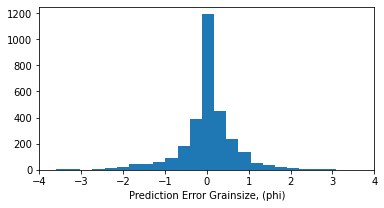

In [16]:
error = preds - y_test.T

plt.figure(figsize=(6,3))
plt.hist(error[0], bins=25)
plt.xlabel('Prediction Error Grainsize, (phi)')
plt.xlim((-4,4))

Text(0.5, 0, 'Catboost Feature Importance')

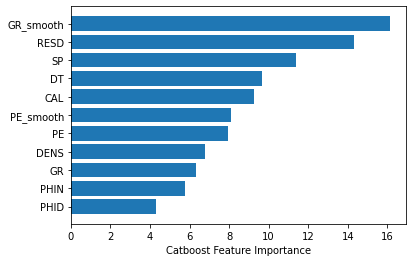

In [17]:
sorted_idx = model2.feature_importances_.argsort()

plt.barh(X.columns[sorted_idx], model2.feature_importances_[sorted_idx])
plt.xlabel("Catboost Feature Importance")

*fin*